In [1]:
try: # if in google colab, download necessary python files
  import google.colab
  ! git clone https://github.com/pesvut/opt-tools.git && mv ./opt-tools/src/*.py .
except ModuleNotFoundError:
  pass
! pip install -qq transformers datasets evaluate zstandard welford einops

In [2]:
import torch
import numpy as np
import pandas as pd
import einops
import matplotlib.pyplot as plt

from model import Model
from texts import prepare
from activations import calculate_attn_crossover, \
    delete_ff_and_evaluate, evaluate_all

In [3]:
opt = Model("125m", limit=1000)
print( "layers:", opt.n_layers, "embedding dimension:", opt.d_model )

- Loaded OPT-125m
 - Registered 12 OPT Attention Layers
layers: 12 embedding dimension: 768


In [4]:
evaluate_all( opt, 1e4 )

No config specified, defaulting to: the_pile/all


  0%|          | 0/10000.0 [00:00<?, ?it/s]

pile loss: 2.9551413443780707
pile no skip: 49.31 %
pile w/ skip: 24.46 %
pile no skip top10: 75.31 %
pile w/ skip top10: 63.82 %


Using custom data configuration codeparrot--codeparrot-clean-valid-826c6fd8b27e5523
Found cached dataset json (/config/.cache/huggingface/datasets/codeparrot___json/codeparrot--codeparrot-clean-valid-826c6fd8b27e5523/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10000.0 [00:00<?, ?it/s]

code loss: 2.3737670137332034
code no skip: 60.27 %
code w/ skip: 20.35 %
code no skip top10: 79.51 %
code w/ skip top10: 63.43 %


{'pile_base': 49.30982061416844,
 'pile_topk': 75.31164487686227,
 'pile_skip': 24.457281848586195,
 'pile_topk_skip': 63.81851459396975,
 'code_base': 60.265700483091784,
 'code_topk': 79.50575994054255,
 'code_skip': 20.35024154589372,
 'code_topk_skip': 63.43422470369282,
 'pile_loss': array(2.95514134),
 'code_loss': array(2.37376701)}

In [5]:
attn_data = calculate_attn_crossover(opt, 1.6, sample_size=1e5)
print( attn_data.keys() )

No config specified, defaulting to: the_pile/all


  0%|          | 0/100000.0 [00:00<?, ?it/s]

Using custom data configuration codeparrot--codeparrot-clean-valid-826c6fd8b27e5523
Found cached dataset json (/config/.cache/huggingface/datasets/codeparrot___json/codeparrot--codeparrot-clean-valid-826c6fd8b27e5523/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100000.0 [00:00<?, ?it/s]

dict_keys(['pile_means', 'pile_pos', 'pile_neg', 'code_means', 'code_pos', 'code_neg', 'crossover_multiple', 'removals'])


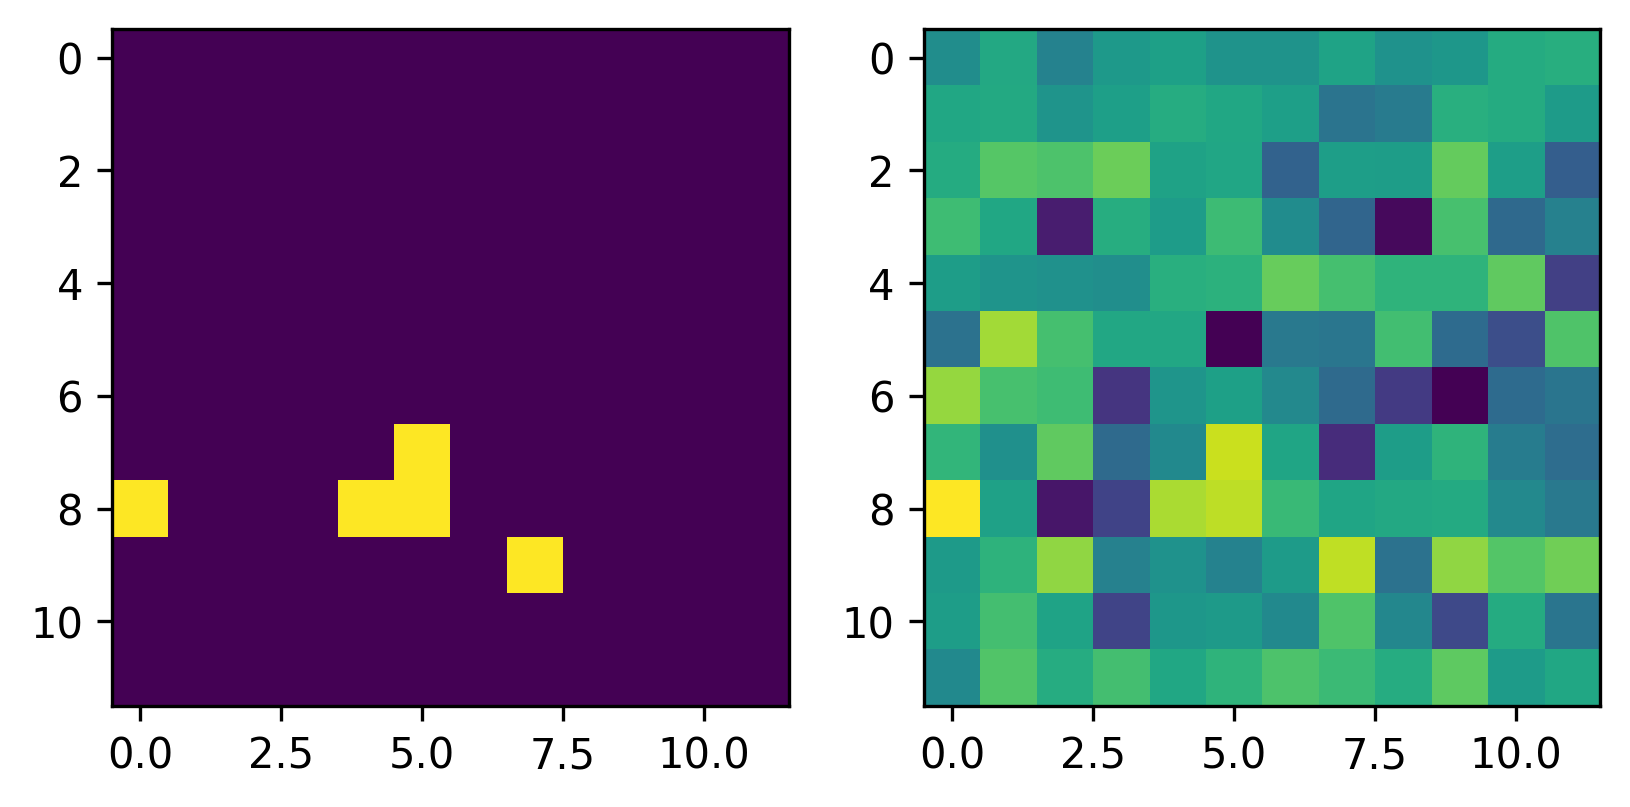

In [6]:
# plot the attn_data
fig, ax = plt.subplots(1, 2)
ax[0].imshow( attn_data['removals'] )
ax[1].imshow( np.log2(attn_data['crossover_multiple']) )
plt.show()

In [7]:
if False:
    print(pile_means[9][0][49])
    print(pile_pos[9][0][49])
    print(pile_neg[9][0][49])

    rel = (pile_pos.flatten()+1e-5) / np.abs(pile_neg.flatten()-1e-5)
    indices = np.argsort( rel )
    plt.hlines( y=0, xmin=0, xmax=len(indices), color='black', linestyle=':', linewidth=0.2 )
    plt.plot( pile_means.flatten()[indices], linewidth=1)
    plt.plot( pile_pos.flatten()[indices]  , linewidth=0.2 )
    plt.plot( pile_neg.flatten()[indices]  , linewidth=0.2 )
    plt.plot( np.log2(rel[indices])/40, linewidth=0.5)

In [8]:
for layer in range(12):
    break
    head = 0
    plt.figure()
    plt.title(f'Layer {layer} Head {head}')
    plt.semilogy( np.abs(pile_neg[layer][head]), base=2 )
    plt.semilogy( pile_pos[layer][head], base=2 )
    plt.semilogy( np.abs(code_neg[layer][head]), ':', base=2)
    plt.semilogy( code_pos[layer][head], ':', base=2)
    plt.show()

In [11]:
pre_removals = ["tmp/125m-ff-2x-criterion_2022-11-30_16:29:53.npy"]
opt.delete_ff_keys_from_files(pre_removals)

 1148 - [79, 143, 147, 88, 132, 132, 67, 70, 66, 102, 122]


In [12]:
df = pd.DataFrame()

# Evaluate model before removal of any neurons
data = evaluate_all( opt, 1e5 )
df = df.append( data, ignore_index=True )
print( df.T )

No config specified, defaulting to: the_pile/all


  0%|          | 0/100000.0 [00:00<?, ?it/s]

pile loss: 3.3249178903619043
pile no skip: 44.39 %
pile w/ skip: 21.54 %
pile no skip top10: 71.51 %
pile w/ skip top10: 59.08 %


Using custom data configuration codeparrot--codeparrot-clean-valid-826c6fd8b27e5523
Found cached dataset json (/config/.cache/huggingface/datasets/codeparrot___json/codeparrot--codeparrot-clean-valid-826c6fd8b27e5523/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100000.0 [00:00<?, ?it/s]

In [ ]:
FREQ_MULTIPLE = 2

for i in range(4):
    print('\n\n- RUNNING RUN No', i )
    data = delete_ff_and_evaluate( opt, FREQ_MULTIPLE )
    df = df.append( data, ignore_index=True )
    print( df.T )



- RUNNING RUN No 0


No config specified, defaulting to: the_pile/all


  0%|          | 0/50000.0 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
for i in range(4,8):
    print('\n\n- RUNNING RUN No', i )
    data = delete_ff_and_evaluate( opt, FREQ_MULTIPLE )
    df = df.append( data, ignore_index=True )
    print( df.T )

In [ ]:
for i in range(8,12):
    print('\n\n- RUNNING RUN No', i )
    data = delete_ff_and_evaluate( opt, FREQ_MULTIPLE )
    df = df.append( data, ignore_index=True )
    print( df.T )